In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSabc/"

In [2]:
lb_h = 0.*np.ones((4,))
ub_h = 3.*np.ones((4,))

lb_dh = -1.*np.ones((2,))
ub_dh = 1.*np.ones((2,))

h = Parameter("h", 4, lb=lb_h, ub=ub_h)
dh = Parameter("dh", 2, lb=lb_dh, ub=ub_dh)
n = Parameter("n", 1, lb=1.99, ub=2.01)
parameters = [h, dh, n]

sigma_eps = 0.1

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
# Define model
name = "V1Circuit"
model = Model(name, parameters)

In [4]:
from epi.example_eps import euler_sim, euler_sim_traj
import tensorflow as tf

X_INIT = tf.constant(np.random.normal(1.0, 0.01, (1, 4, 1)).astype(np.float32))


def V1_sim(h, dh, n):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
    n = n[:, :, None]
    
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    W = tf.constant(_W, dtype=tf.float32)

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t

# Define eps
diff_prod_mean = -0.5
diff_sum_mean = 0.
def SV_flip(h, dh, n):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
    n = n[:, :, None]
    
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    W = tf.constant(_W, dtype=tf.float32)

    def f1(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + noise) ** n)) / tau

    def f2(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    ss1 = euler_sim(f1, x_init, dt, T)
    ss2 = euler_sim(f2, x_init, dt, T)
    
    diff1 = ss1[:,2]-ss1[:,3]
    diff2 = ss2[:,2]-ss2[:,3]
    diff_prod = diff1*diff2
    diff_sum = diff1+diff2
    T_x = tf.stack((diff_prod, 
                    diff_sum, 
                    (diff_prod - diff_prod_mean) ** 2, 
                    (diff_sum-diff_sum_mean) ** 2), axis=1)

    return T_x



model.set_eps(SV_flip)

In [5]:
D = sum([param.D for param in model.parameters])
lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])
print(D, lb)

7 [ 0.    0.    0.    0.   -1.   -1.    1.99]


In [6]:
M = 1000
num_keep = 500

mean = [-0.5, 0.]
std = [0.25, 0.25]

def accept_inds(T_x, mean ,std):
    return np.logical_and(np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0]),
                          np.logical_and(mean[1]-2*std[1] < T_x[:,1], T_x[:,1] < mean[1]+2*std[1]))

num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D))
    for j in range(D):
        _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]



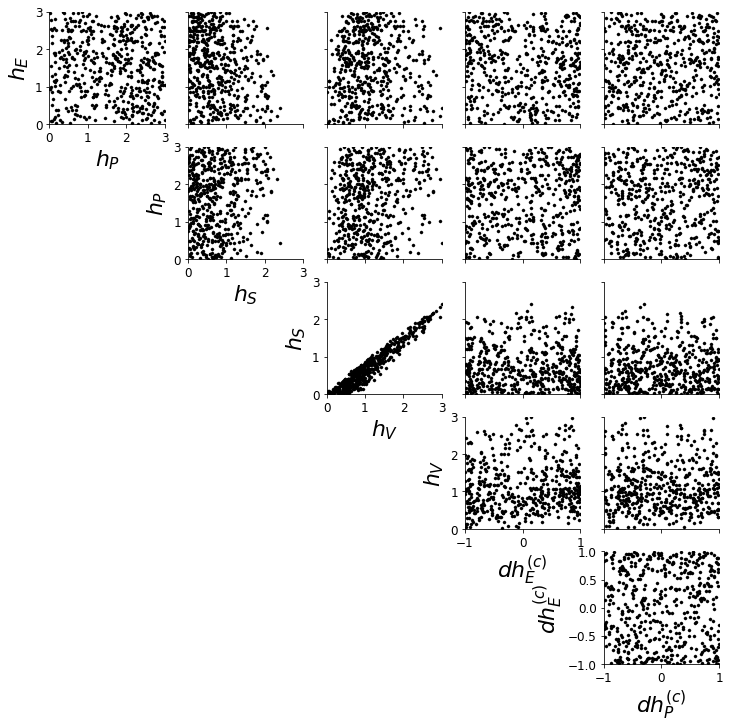

In [7]:
num_plot = 500
fontsize = 14
z_labels = [r'$h_E$', r'$h_P$', r'$h_S$', r'$h_V$', r'$dh^{(c)}_E$', r'$dh^{(c)}_P$', 'n', r'$\epsilon$']
fig = pairplot(z[:num_plot], np.arange(6), z_labels,
               fontsize=22,
               lb=lb, ub=ub,
               c = None)
plt.savefig(figdir + 'SV_flip_ABC_z.png')
               #c_label='prod')

In [8]:
T_x_sim = model.eps(z).numpy()

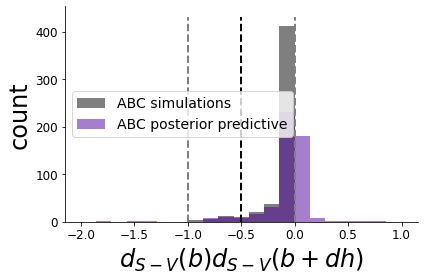

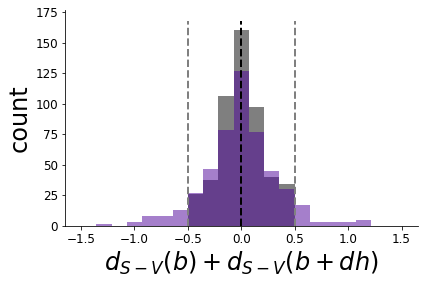

In [9]:
from epi.util import plot_T_x 

nbins=21
xmins = [-2, -1.5]
xmaxs = [1, 1.5]
xlabels = [r"$d_{S-V}(b)d_{S-V}(b+dh)$",
           r"$d_{S-V}(b) + d_{S-V}(b+dh)$"]

if diff_prod_mean == -0.25:
    mu = np.array([-0.25, 0.0, 0.125**2, 0.125**2])
else:
    mu = np.array([-0.5, 0.0, 0.25**2, 0.25**2])

for i in range(2):
    ax = plot_T_x(T_x[:,i], T_x_sim[:,i], bins=nbins, 
                 x_mean=mu[i], x_std=np.sqrt(mu[i+2]),
                 xmin=xmins[i], xmax=xmaxs[i], 
                 xlabel=xlabels[i], ylim=None, fontsize=24)
    if i==0:
        plt.legend()
    plt.tight_layout()
    plt.savefig(figdir + 'SVflip_ABC_Tx%d.png' % (i+1))

In [10]:
sigma_eps = 0.1
def plot_z_mode_sims(z, log_q_z, M=200):
    best_z = np.argmax(log_q_z)
    z_mode = z[best_z][None,:]
    h = z_mode[:,:4]
    dh = z_mode[:,4:]

    def V1_sim(h, dh):
        h = h[:, :, None]
        dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]

        n = 2.
        dt = 0.005
        T = 100
        tau = 0.02

        _x_shape = tf.ones_like(h, dtype=tf.float32)
        x_init = _x_shape*X_INIT

        npzfile = np.load("data/V1_Zs.npz")
        _W = npzfile["Z_allen_square"][None, :, :]
        _W[:, :, 1:] = -_W[:, :, 1:]
        W = tf.constant(_W, dtype=tf.float32)

        def f(y):
            omega = tf.random.normal(y.shape, 0., 1.)
            noise = sigma_eps*omega
            return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

        r_t = euler_sim_traj(f, x_init, dt, T)
        return r_t


    _h = np.tile(h, [M, 1])
    _dh = np.tile(dh, [M, 1])
    r_ts = []
    gammas = np.concatenate((np.array([0,1,]), np.linspace(-1., 2., 101)))
    for gamma in gammas:
        r_ts.append(V1_sim(_h, gamma*_dh))
    r_ts = np.array(r_ts)
    mean_r_ts = np.mean(r_ts, axis=1)
    std_r_ts = np.std(r_ts, axis=1)

    t = 0.005*np.arange(101)
    fig, axs = plt.subplots(1,3, figsize=(15,4))

    for i in range(4):
        axs[0].plot(t, mean_r_ts[0,i,:], c=colors[i])
        axs[0].fill_between(t, 
                            mean_r_ts[0,i,:]-std_r_ts[0,i,:],
                            mean_r_ts[0,i,:]+std_r_ts[0,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[1].plot(t, mean_r_ts[1,i,:], c=colors[i])
        axs[1].fill_between(t, 
                            mean_r_ts[1,i,:]-std_r_ts[1,i,:],
                            mean_r_ts[1,i,:]+std_r_ts[1,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[2].plot(gammas[2:], mean_r_ts[2:,i,-1], c=colors[i])
        axs[2].fill_between(gammas[2:], 
                            mean_r_ts[2:,i,-1]-std_r_ts[2:,i,-1],
                            mean_r_ts[2:,i,-1]+std_r_ts[2:,i,-1],
                            facecolor=colors[i], alpha=0.5)
        
    axs[0].set_xlabel(r'$t$')
    axs[0].set_ylabel(r'$r(t)$')
    axs[0].set_title(r'$h$')
    axs[0].set_ylim([0, 7])
    
    axs[1].set_xlabel(r'$t$')
    axs[1].set_ylabel(r'$r(t)$')
    axs[1].set_title(r'$h+dh$')
    axs[1].set_ylim([0, 7])
    
    axs[2].set_xlabel(r'$\gamma$')
    axs[2].set_ylabel(r'$r_{ss}$')
    axs[2].set_title(r'$h+ \gamma dh$')
    axs[2].set_ylim([0, 7])

    plt.show()
    return z_mode



In [11]:
npzfile = np.load('SV_mode.npz')
z_mode = npzfile['z_mode1']
h = z_mode[0,:4]
plot_z_mode_sims(z_mode, np.array([1]), subscript=1, M=200)

TypeError: plot_z_mode_sims() got an unexpected keyword argument 'subscript'

In [ ]:
def V1_sim(h, dh):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
   
    n = 2.
    sigma_eps = 0.1
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    _W = _W / (1. / _W[0,0,0])
    W = tf.constant(_W, dtype=tf.float32)

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t

In [ ]:
h = z[:,:4]
dh = z[:,4:6]
r_t1s = []
r_t2s = []
r_t1s = V1_sim(h, 0.*dh)
r_t2s = V1_sim(h, dh)
   
SV_diff = (r_t2s[:,2,-1] - r_t2s[:,3,-1]).numpy()

plt.figure()
plt.hist(SV_diff[dh[:,0] < 0.], alpha=0.5)
plt.hist(SV_diff[dh[:,0] >= 0.], alpha=0.5)
plt.show()

In [ ]:
print(r_t1s.shape)
t = 0.005*np.arange(101)
plt.figure()

for j in range(10):
    plt.figure()
    for i in range(4):
        plt.plot(t, r_t1s[j,i,:], c=colors[i])
    plt.show()